# Reducing Customer Churn For Telco
## What are the drivers for churn
### By Matthew Mays
9/23/2020

# Goals
### Find drivers of churn
### Accurately predict churn

In [1]:
from acquire import get_telco_data
from prepare import prep_telco_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Acquiring The Data
As well as some initial analysis

In [2]:
# Use acquire function to get telco data set
telco = get_telco_data()
telco

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.90,542.4,No,DSL,Month-to-month,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.40,571.45,No,DSL,Month-to-month,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.20,340.35,No,DSL,Month-to-month,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.10,25.1,Yes,DSL,Month-to-month,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.50,30.5,Yes,DSL,Month-to-month,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,4,3,3,9950-MTGYX,Male,0,Yes,Yes,28,Yes,...,No internet service,No internet service,No internet service,Yes,20.30,487.95,No,None,Two year,Credit card (automatic)
7039,2,3,3,9953-ZMKSM,Male,0,No,No,63,Yes,...,No internet service,No internet service,No internet service,No,25.25,1559.3,No,None,Two year,Mailed check
7040,4,3,3,9964-WBQDJ,Female,0,Yes,No,71,Yes,...,No internet service,No internet service,No internet service,Yes,24.40,1725.4,No,None,Two year,Credit card (automatic)
7041,3,3,3,9972-EWRJS,Female,0,Yes,Yes,67,Yes,...,No internet service,No internet service,No internet service,Yes,19.25,1372.9,No,None,Two year,Bank transfer (automatic)


In [3]:
# A quick look into the data set shows that most of the columns are object types.
# While monthly charges are a float total charges are an object which means there might be something going on there.
telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   contract_type_id          7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [4]:
# Taking a look at the describe method might shed some light on that.
# It seems that tenure has a minimum value of 0 which might cause some issues with total charges
telco.describe()

,payment_type_id,contract_type_id,internet_service_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.690473,1.872923,0.162147,32.371149,64.761692
std,1.148907,0.833755,0.737796,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,1.000000,2.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


In [91]:
for col in telco:
    if col !='customer_id' and col != 'monthly_charges' and col != 'total_charges' and col != 'tenure':
        print(telco[col].value_counts())
        print()

1    2365
2    1612
3    1544
4    1522
Name: payment_type_id, dtype: int64

1    3875
3    1695
2    1473
Name: contract_type_id, dtype: int64

2    3096
1    2421
3    1526
Name: internet_service_type_id, dtype: int64

Male      3555
Female    3488
Name: gender, dtype: int64

0    5901
1    1142
Name: senior_citizen, dtype: int64

No     3641
Yes    3402
Name: partner, dtype: int64

No     4933
Yes    2110
Name: dependents, dtype: int64

Yes    6361
No      682
Name: phone_service, dtype: int64

No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64

No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64

No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64

No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64

No                     

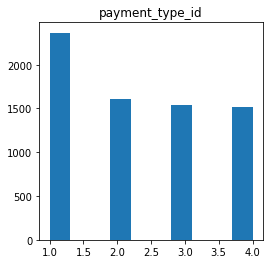

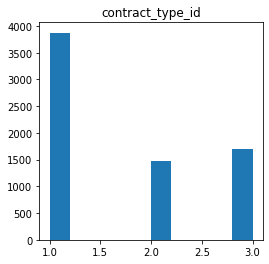

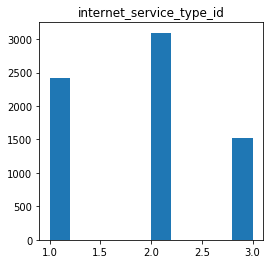

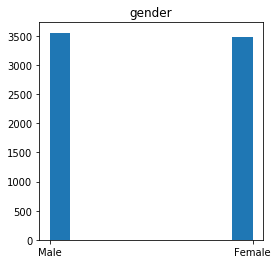

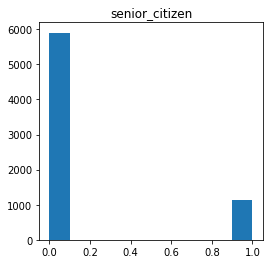

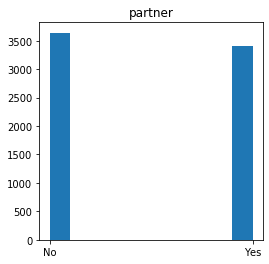

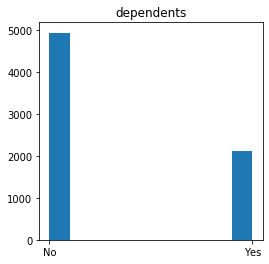

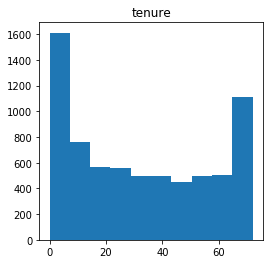

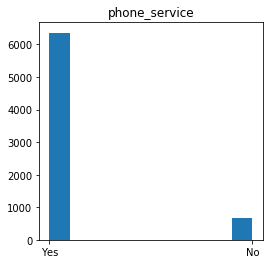

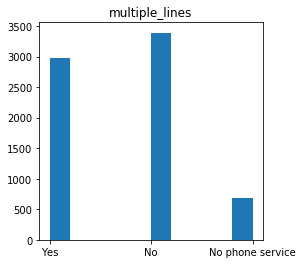

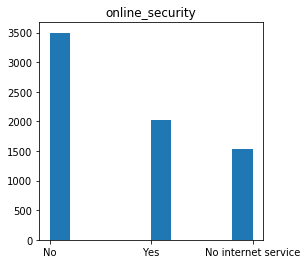

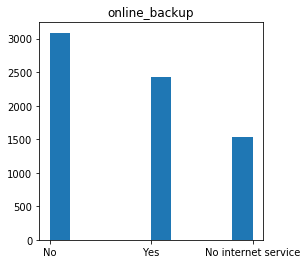

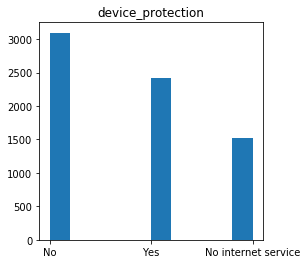

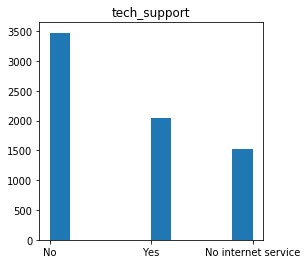

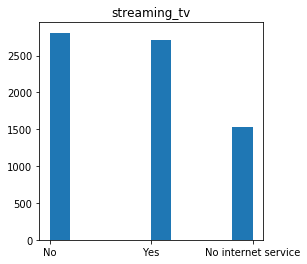

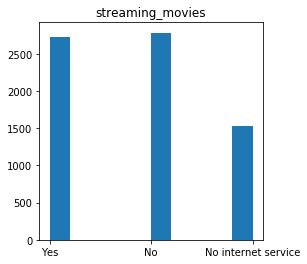

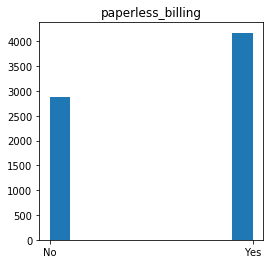

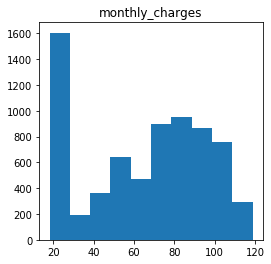

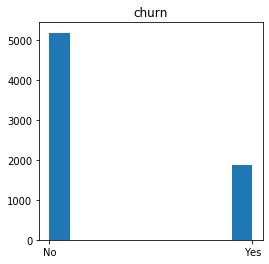

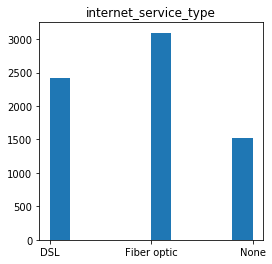

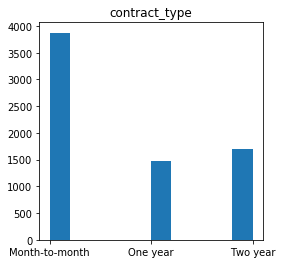

In [6]:
for col in telco.columns:
    if col != 'customer_id' and col != 'total_charges' and col != 'payment_type':
        plt.figure(figsize=(4, 4))
        plt.hist(telco[col])
        plt.title(col)
        plt.show()

- There aren't any outliers
- There are noticable minorities in seniors and customers without phone service.
- gender is fairly close
- monthly charges has a huge spike in customers with low monthly charges but that is most likely due to how many customers only have phone service

### Preparation
- convert object columns with binary values to 0s and 1s
    - rename gender column to male with (male = 1 and female = 0)
- rename tenure to monthly_tenure
- add a column for tenure years
- remove duplicates
- convert total_charges to float
- handle nulls (none found in this set)
- There were 11 white space values in total charges due to those customers having a monthly tenure of 0
    - removed the 11 rows where tenure was 0 because in a set of 7,000+ 11 rows isn't a huge deal.
- Make a variable for customers that only have fiber optic internet
- split into train, validate, test

In [7]:
train, validate, test = prep_telco_data()

/Users/matthewmays/codeup-data-science/classification_project/prepare.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.drop(df[((df['monthly_tenure'].sort_values() == 0))].index)


In [8]:
train

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,male,senior_citizen,partner,dependents,monthly_tenure,phone_service,...,total_charges,churn,internet_service_type,contract_type,payment_type,is_automatic_payment,phone_lines,yearly_tenure,part_depend,fiber
5399,4,3,1,0757-WCUUZ,1,0,1,1,54,1,...,3409.10,0,DSL,Two year,Credit card (automatic),1,1,4.50,2,0
2876,4,1,2,7603-USHJS,1,0,0,1,12,1,...,871.40,1,Fiber optic,Month-to-month,Credit card (automatic),1,1,1.00,1,1
659,3,1,1,5311-IHLEI,1,0,0,0,12,0,...,605.75,0,DSL,Month-to-month,Bank transfer (automatic),1,0,1.00,0,0
5843,3,3,1,7975-JMZNT,1,0,1,0,66,1,...,6075.90,0,DSL,Two year,Bank transfer (automatic),1,1,5.50,1,0
2229,2,1,2,4660-IRIBM,1,0,1,1,18,1,...,1500.50,0,Fiber optic,Month-to-month,Mailed check,0,0,1.50,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200,1,1,2,9355-NPPFS,0,1,0,0,26,1,...,2006.10,0,Fiber optic,Month-to-month,Electronic check,0,0,2.17,0,1
4246,1,2,1,6576-FBXOJ,1,0,1,0,17,0,...,934.80,0,DSL,One year,Electronic check,0,0,1.42,1,0
2517,1,1,2,5937-EORGB,1,1,1,0,15,1,...,1392.25,0,Fiber optic,Month-to-month,Electronic check,0,1,1.25,1,1
6236,1,3,2,6297-NOOPG,0,0,1,0,70,1,...,7752.05,0,Fiber optic,Two year,Electronic check,0,1,5.83,1,1


In [9]:
train.describe()

,payment_type_id,contract_type_id,internet_service_type_id,male,senior_citizen,partner,dependents,monthly_tenure,phone_service,online_security,...,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,is_automatic_payment,phone_lines,yearly_tenure,part_depend,fiber
count,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,...,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000
mean,2.315723,1.696977,1.872746,0.506477,0.160528,0.480061,0.300737,32.560579,0.903734,1.064008,...,1.165862,0.594107,64.378004,2272.043320,0.264669,0.433325,0.417577,2.713152,0.780798,0.433833
std,1.156960,0.830304,0.741696,0.500022,0.367142,0.499666,0.458637,24.326705,0.294993,0.706364,...,0.759876,0.491126,30.219484,2244.982546,0.441213,0.495597,0.493222,2.027554,0.816781,0.495666
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,18.400000,18.850000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,1.000000,...,1.000000,0.000000,35.000000,408.500000,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000
50%,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,...,1.000000,1.000000,70.100000,1398.600000,0.000000,0.000000,0.000000,2.420000,1.000000,0.000000
75%,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,2.000000,...,2.000000,1.000000,89.850000,3751.150000,1.000000,1.000000,1.000000,4.580000,1.000000,1.000000
max,4.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,...,2.000000,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,6.000000,2.000000,1.000000


### Takeaways
There is about a 26% churn rate 
There is roughly a 50% split on gender
90% of our customers have phone service
Only 16% of this data set is seniors

### Exploration

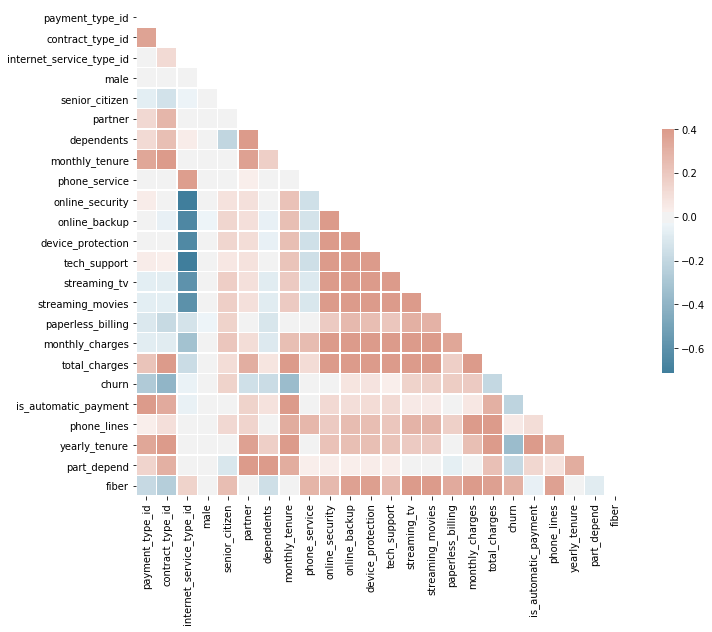

In [10]:
# Creating a heat map will show each features correlation to each other
# The most import section is how churn correlates to everything else
corr = train.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=[13, 9])
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5})

- The highest correlations are the darker blue or red colors.
- The darkest colors for churn are payment_type, contract_type, monthly_tenure, monthly_charges, and total_charges.
- We will be ignoring contract type because we can't change contracts
    - while tenure is on there that can only be increased by convincing customers to stay with us for longer
    - total charges falls under the same line as tenure

- I will be looking into payment_type and monthly_charges
- monthly charges seems to be correlated with internet service type
    - whether or not a customer had fiber optic internet or not seems to correlate strongly with monthly charges

### Monthly Charges

Text(0.5, 1.0, 'Non Churned Customers')

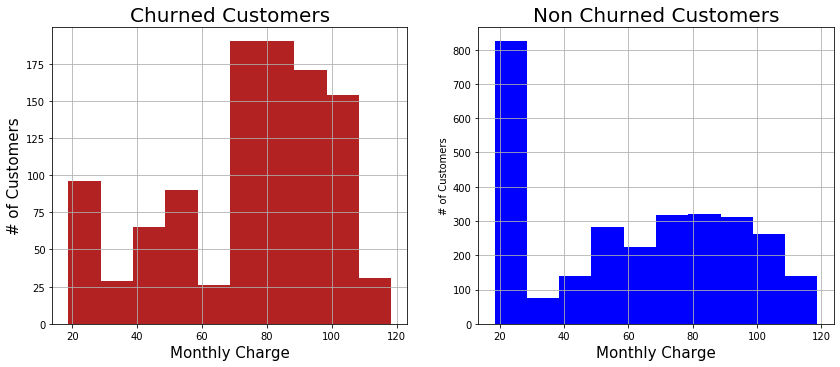

In [11]:
# Setting figure size
plt.figure(figsize=(14, 12))

# plot churned customer monthly charges
plt.subplot(221)
churned_charges = train[train.churn == 1].monthly_charges
churned_charges.hist(color='firebrick')
plt.xlabel('Monthly Charge', fontsize=15)
plt.ylabel('# of Customers', fontsize=15)
plt.title('Churned Customers', fontsize=20)

# plot non churned customer monthly charges
plt.subplot(222)
nonchurned_charges = train[train.churn == 0].monthly_charges
nonchurned_charges.hist(color='blue')
plt.xlabel('Monthly Charge', fontsize=15)
plt.ylabel('# of Customers')
plt.title('Non Churned Customers', fontsize=20)

It seems customers who have churned paid more per month on average than customers that are still with the company.

### Hypothesis Test

### Monthly Charges

H0: Churned customer average monthly charges are <= non churned customer average monthly charges  
Ha: Churned customer average monthly charges are > non churned customer average monthly charges

In [12]:
# Running a one tailed two sample t-test to test hypothesis
# alpha is set to .05

# we created dataframes already that contain churned and non churned customer monthly charges when plotting
# churned_charges and nonchurned_charges

# run t-test
t, p = stats.ttest_ind(churned_charges, nonchurned_charges, equal_var=False)

# printing results
print(f't: {t}')
print(f'p: {p/2}')

t: 13.358066071259712
p: 1.620739508721089e-39


Because t > 0 and p/2 < alpha we reject the null hypothesis.  
This means that churned customers are on average paying more than customers who haven't churned as we found in the histograms.  
The difference in prices might be on of the driving factors of churn.

### Automatic Payment

Text(0.5, 1.0, 'Automatic Paying Customers')

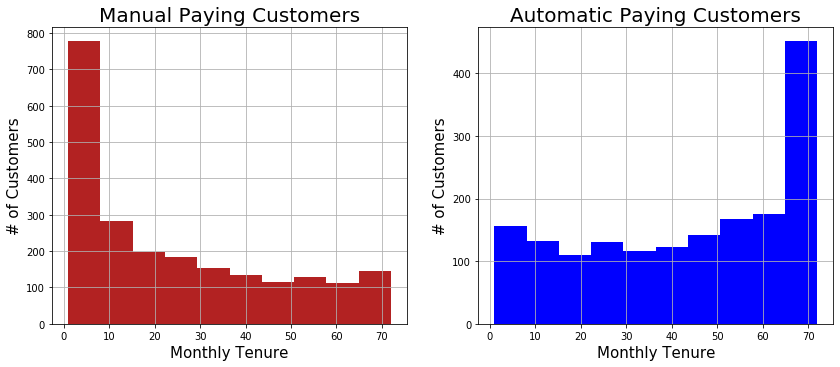

In [13]:
plt.figure(figsize=(14,12))

plt.subplot(221)
manual_plans = train[train.is_automatic_payment == 0].monthly_tenure
manual_plans.hist(color='firebrick')
plt.xlabel('Monthly Tenure', fontsize=15)
plt.ylabel('# of Customers', fontsize=15)
plt.title('Manual Paying Customers', fontsize=20)

plt.subplot(222)
automatic_plans = train[train.is_automatic_payment == 1].monthly_tenure
automatic_plans.hist(color='blue')
plt.xlabel('Monthly Tenure', fontsize=15)
plt.ylabel('# of Customers', fontsize=15)
plt.title('Automatic Paying Customers', fontsize=20)

It seems from these plots that customers on automatic payment plans stay longer with the company on average.

HO: A customer having their payment plan be automatic has no effect on how long they stay with the company.  
Ha: A customer stays longer with the company on average with an automatic payment plan.

In [14]:
# Running a one tailed two sample t-test to test hypothesis
# alpha is set to .05
# run t-test
t, p = stats.ttest_ind(automatic_plans, manual_plans, equal_var = False)

# print results
print(f't: {t}')
print(f'p: {p/2}')

t: 27.026729933108832
p: 6.836884909023058e-147


Because t > 0 and p/2 < alpha we reject the null hypothesis.  
This means that customers with automatic payment plans are infact more likely to stay with the company for longer.  
This could simply be because of the convenience as well as customers being more likely to keep their plans if they aren't manually sending checks every time they pay.

### Fiber Optic

Text(0.5, 1.0, 'Non Fiber Paying Customers')

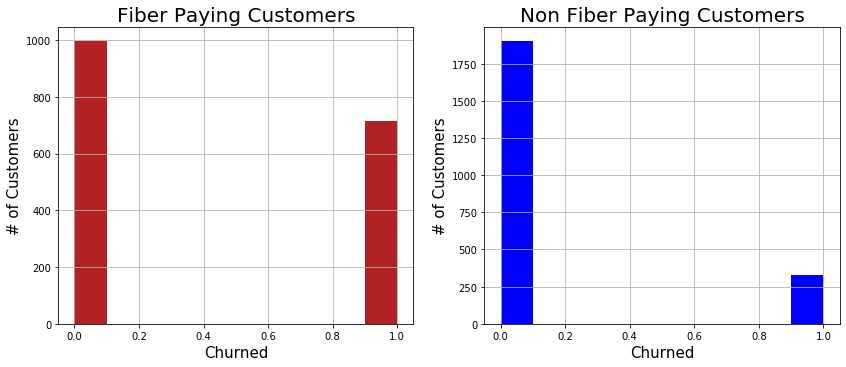

In [15]:
plt.figure(figsize=(14,12))

plt.subplot(221)
fiber_plans = train[train.fiber == 1].churn
fiber_plans.hist(color='firebrick')
plt.xlabel('Churned', fontsize=15)
plt.ylabel('# of Customers', fontsize=15)
plt.title('Fiber Paying Customers', fontsize=20)

plt.subplot(222)
nonfiber_plans = train[train.fiber == 0].churn
nonfiber_plans.hist(color='blue')
plt.xlabel('Churned', fontsize=15)
plt.ylabel('# of Customers', fontsize=15)
plt.title('Non Fiber Paying Customers', fontsize=20)

It seems from these plots that customers that pay for fiber optic are more likely to churn that customers that aren't.

HO: A customer that has the fiber optic plan is not any more likely to churn than customers that don't have the fiber optic plan  
Ha: A customer that has the fiber optic plan is more likely to churn than customers that don't have the fiber optic plan

In [32]:
# Both fiber and churn are categorical variables
# We will be using a chi square test to test the hypothesis

# alpha is set to .05

table = pd.crosstab(train.churn, train.fiber)
print('Crosstab of churn and fiber:\n\n',table)

chi2, p, degf, expected = stats.chi2_contingency(table)

print(f'p: {p}')

Crosstab of churn and fiber:

 fiber     0    1
churn           
0      1900  995
1       329  713
p: 2.2724715071264876e-80


Because p < alpha we reject the null hypothesis.  
This means that customers with fiber plans are in fact more likely to churn than those that aren't on fiber plans.

### Overall Eploration Takeaways  
Monthly charges seems to have an effect on whether a customer is more likely to churn or not.  
Whether a customer pays through an automatic payment plan or a manual plan seems to effect how long they stay with the company.

## Modeling
We will be using the monthly charges and is automatic variables to create our models.  
Because our main goal is to predict whether a customer churns or not and we aren't all too worried about false positive/false negatives we are going to be looking at accuracy as our most important metric.

### Baseline
First up we will need a baseline to compare our models accuracy to just simply guessing.

In [17]:
# Create new baseline df so we don't mess with any data on the original df
train_baseline = train
# Create new column on baseline df that has predicts that no one will churn because that is the most common value.
train_baseline['baseline_prediction'] = 0
train_baseline.head(5)

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,male,senior_citizen,partner,dependents,monthly_tenure,phone_service,...,churn,internet_service_type,contract_type,payment_type,is_automatic_payment,phone_lines,yearly_tenure,part_depend,fiber,baseline_prediction
5399,4,3,1,0757-WCUUZ,1,0,1,1,54,1,...,0,DSL,Two year,Credit card (automatic),1,1,4.5,2,0,0
2876,4,1,2,7603-USHJS,1,0,0,1,12,1,...,1,Fiber optic,Month-to-month,Credit card (automatic),1,1,1.0,1,1,0
659,3,1,1,5311-IHLEI,1,0,0,0,12,0,...,0,DSL,Month-to-month,Bank transfer (automatic),1,0,1.0,0,0,0
5843,3,3,1,7975-JMZNT,1,0,1,0,66,1,...,0,DSL,Two year,Bank transfer (automatic),1,1,5.5,1,0,0
2229,2,1,2,4660-IRIBM,1,0,1,1,18,1,...,0,Fiber optic,Month-to-month,Mailed check,0,0,1.5,2,1,0


In [18]:
# calculate accuracy of the baseline model
base_acc = round((train_baseline['baseline_prediction'] == train_baseline['churn']).mean(), 2)
print(f'Accuracy of baseline model: {base_acc * 100}%')

Accuracy of baseline model: 74.0%


### Training Models
We are looking for models that beat the baseline accuracy of 74%

### Model 1
**Type:** Logistic Regression  

**Features:**
- is_automatic_payment
-  monthly_charges  
- fiber


**Hyper Parameters:**
- We will be using the basic parameters

In [37]:
# Create dfs with selected features for logistic regression model
X_train1 = train[['is_automatic_payment', 'monthly_charges', 'fiber']]
y_train = train.churn

# Create and fit logistic regression model
m1_logit = LogisticRegression(random_state=123)
m1_logit = m1_logit.fit(X_train1, y_train)

m1_pred = pd.DataFrame(m1_logit.predict(X_train1))

In [38]:
# Check to see how the model does in its predictions
print(classification_report(y_train, m1_pred))
print(confusion_matrix(y_train, m1_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      2895
           1       0.56      0.39      0.46      1042

    accuracy                           0.76      3937
   macro avg       0.68      0.64      0.65      3937
weighted avg       0.74      0.76      0.74      3937

[[2572  323]
 [ 634  408]]


Model 1 is slightly more accurate than the baseline model with a 76% accuracy.  
This model will move on to validate to test if it is better.

### Model 2  
**Type:** Random Forest  

**Features:**
- is_automatic_payment
- monthly charges
- fiber

**HyperParameters:**
- n_estimators = 100
- max_depth = 12
- min_samples_leaf = 1

In [81]:
# Because we are using the same features as model 1 we will just use that models X and y
# Create and fit random forest model
m2_rf = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf=1, random_state=123)
m2_rf = m2_rf.fit(X_train1, y_train)

m2_pred = pd.DataFrame(m2_rf.predict(X_train1))

In [82]:
print(classification_report(y_train, m2_pred))
print(confusion_matrix(y_train, m2_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.90      2895
           1       0.78      0.55      0.65      1042

    accuracy                           0.84      3937
   macro avg       0.82      0.75      0.77      3937
weighted avg       0.83      0.84      0.83      3937

[[2732  163]
 [ 467  575]]


Model 2 is a little more accurate than the baseline at 84% accuracy. This comes out to about 10% more accurate than the baseline.  
This model will move on to validate to test if it is better or just simply overfitting the training data.

### Model 3
**Type:** Decision Tree  
**Features:**
- is_automatic_payment
- monthly charges
- fiber

**HyperParameters:**
- max_depth = 12

In [41]:
m3_tree = DecisionTreeClassifier(max_depth=12, random_state=123)
m3_tree = m3_tree.fit(X_train1, y_train)

m3_pred = pd.DataFrame(m3_tree.predict(X_train1))

In [42]:
print(classification_report(y_train, m3_pred))
print(confusion_matrix(y_train, m3_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2895
           1       0.67      0.53      0.59      1042

    accuracy                           0.81      3937
   macro avg       0.76      0.72      0.73      3937
weighted avg       0.80      0.81      0.80      3937

[[2629  266]
 [ 490  552]]


Model 3 has a better accuracy than the baseline at 81%. This also comes out to being about 7% higher than the baseline.  
This model will move on to validate to test if it is better or just simply overfitting the training data.

### Training Results
- Baseline Model Accuracy: 74%
- Model 1 Accuracy: 76%
- Model 2 Accuracy: 79%
- Model 3 Accuracy: 81%

Models 2 and 3 are moving on to the validate phase

## Modeling (Validation)

### Model 1 (Logistic Regression)

In [49]:
# Create dfs with selected features for validation data
X_validate = validate[['is_automatic_payment', 'monthly_charges', 'fiber']]
y_validate = validate.churn

# make predictions on validation set
m1_val_pred = pd.DataFrame(m1_logit.predict(X_validate))

In [50]:
print(classification_report(y_validate, m1_val_pred))
print(confusion_matrix(y_validate, m1_val_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1255
           1       0.54      0.40      0.46       433

    accuracy                           0.76      1688
   macro avg       0.68      0.64      0.65      1688
weighted avg       0.74      0.76      0.75      1688

[[1107  148]
 [ 259  174]]


### Model 2 (Random Forest)

In [83]:
m2_val_pred = pd.DataFrame(m2_rf.predict(X_validate))

In [84]:
print(classification_report(y_validate, m2_val_pred))
print(confusion_matrix(y_validate, m2_val_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1255
           1       0.53      0.39      0.45       433

    accuracy                           0.76      1688
   macro avg       0.67      0.64      0.65      1688
weighted avg       0.74      0.76      0.74      1688

[[1107  148]
 [ 264  169]]


### Model 3 (Decision Tree)

In [45]:
m3_val_pred = pd.DataFrame(m3_tree.predict(X_validate))

In [46]:
print(classification_report(y_validate, m3_val_pred))
print(confusion_matrix(y_validate, m3_val_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1255
           1       0.51      0.42      0.46       433

    accuracy                           0.75      1688
   macro avg       0.66      0.64      0.65      1688
weighted avg       0.73      0.75      0.74      1688

[[1076  179]
 [ 249  184]]


### Validation Takeaways
- Model 1 Accuracy: 76%
- Model 2 Accuracy: 76%
- Model 3 Accuracy: 75%

Because model 2 had such a big drop in accuracy from train to validate and it has the same accuracy in validation as model 1 I will be pushing model 1 to test as it has been more consistent.

In [61]:
X_test = test[['is_automatic_payment', 'monthly_charges', 'fiber']]
y_test = test.churn

m2_test_pred = pd.DataFrame(m1_logit.predict(X_test))

In [62]:
print(classification_report(y_test, m2_test_pred))
print(confusion_matrix(y_test, m2_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1013
           1       0.59      0.40      0.48       394

    accuracy                           0.75      1407
   macro avg       0.69      0.65      0.66      1407
weighted avg       0.73      0.75      0.74      1407

[[901 112]
 [236 158]]


### Testing Takeaways
Model 1 has proven to be the best model, it beats the baseline and it can predict churn on unseen data with an accuracy of 75%

## Predictions
Now we will take model 1 and use it to make predictions on the entire original dataset to observe how it performs.

In [86]:
# Recreate dataframe before the split by concat all 3 dataframes
full_dataset = pd.concat([train, validate, test])
full_dataset

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,male,senior_citizen,partner,dependents,monthly_tenure,phone_service,...,churn,internet_service_type,contract_type,payment_type,is_automatic_payment,phone_lines,yearly_tenure,part_depend,fiber,baseline_prediction
5399,4,3,1,0757-WCUUZ,1,0,1,1,54,1,...,0,DSL,Two year,Credit card (automatic),1,1,4.50,2,0,0.0
2876,4,1,2,7603-USHJS,1,0,0,1,12,1,...,1,Fiber optic,Month-to-month,Credit card (automatic),1,1,1.00,1,1,0.0
659,3,1,1,5311-IHLEI,1,0,0,0,12,0,...,0,DSL,Month-to-month,Bank transfer (automatic),1,0,1.00,0,0,0.0
5843,3,3,1,7975-JMZNT,1,0,1,0,66,1,...,0,DSL,Two year,Bank transfer (automatic),1,1,5.50,1,0,0.0
2229,2,1,2,4660-IRIBM,1,0,1,1,18,1,...,0,Fiber optic,Month-to-month,Mailed check,0,0,1.50,2,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4275,2,2,1,6994-ORCWG,0,0,0,0,14,1,...,0,DSL,One year,Mailed check,0,1,1.17,0,0,NaN
2612,1,1,2,6372-RFVNS,0,0,1,0,1,1,...,1,Fiber optic,Month-to-month,Electronic check,0,0,0.08,1,1,NaN
2765,1,1,2,7137-RYLPP,1,1,1,0,37,1,...,1,Fiber optic,Month-to-month,Electronic check,0,1,3.08,1,1,NaN
4898,3,2,2,8329-UTMVM,1,1,0,0,27,1,...,0,Fiber optic,One year,Bank transfer (automatic),1,1,2.25,0,1,NaN


In [87]:
# creating df with selected features for model 1
m1_X_full = full_dataset[['is_automatic_payment', 'monthly_charges', 'fiber']]
m1_y_full = full_dataset.churn

m1_pred_full = pd.DataFrame(m1_logit.predict(m1_X_full))

print(classification_report(m1_y_full, m1_pred_full))
print(confusion_matrix(m1_y_full, m1_pred_full))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      5163
           1       0.56      0.40      0.46      1869

    accuracy                           0.76      7032
   macro avg       0.68      0.64      0.65      7032
weighted avg       0.74      0.76      0.74      7032

[[4580  583]
 [1129  740]]


Model 1 maintained and slightly exceeded its 75% accuracy while predicting churn for the entire dataset. While it went up 1% this could mean it was only a slight increase and got bumped up due to rounding.

In [90]:
m1_pred_prob = pd.DataFrame(m1_logit.predict_proba(m1_X_full))
m1_pred_prob = m1_pred_prob.drop(0, axis=1)
m1_pred_prob['customer_id'] = full_dataset.customer_id
m1_pred_prob['model_1_prediction'] = m1_pred_full
m1_pred_prob.rename(columns={1:'probability_of_churn'}, inplace=True)
m1_pred_prob = m1_pred_prob[['customer_id', 'probability_of_churn', 'model_1_prediction']]
m1_pred_prob.to_csv('predictions.csv')

### Prediction Takeaways
model 1's performance metrics on overall data:
- Accuracy: 76%
- Recall: 40%
    - Does a poor job at predicting churn when a customer will actually churn
- Precision: 56%
    - a little more than half the time that the model predicts a positive it is correct
- f1-score: 46%
    - Our best method to improve upon the f1 score in the future is by improving our weakest metric, recall

## Conclusion
Summarizing what we learned from our analysis and modeling. I'll summarize my model, my recommendations, and the next steps to improve upon this further in the future.

### Analysis Conclusions
Exploration revealed that some drivers of churn are:
- monthly charges
- automatic vs manual payments
- whether or not a customer has fiber optic package

The average monthly charges of our customers that churned are higher than the average monthly charges of the customers that didn't churn.  
Our customers that are on an automatic payment plan tend to stay with us for longer than those who pay manually.  
Customers that are paying for fiber optic internet tend to churn more often than those aren't.

### Recommendations

My recommendation to reduce churn is a two step plan.  
First we should offer our customers that are currently paying for our services manually a discounted rate if they were to swap to an automatic payment plan.  
This has the benefit of not only getting customers on an automatic payment plan but also reducing their monthly charges in which case both will help reduce their probability of churning.  

Second, we should give a general price reduction on our customers that are paying for the fiber optic package seeing as customers with that package are more likely to churn than those on DSL or without internet.

### Model Summarization
I created a model that identified the variables monthly charges, automatic vs manual payments, and fiber optic customers.
- This model maintained an accuracy of around 75-76% on both in and out of sample data
- The models biggest fault is its recall so if our churn rate were to increase in the future the model would become less accurate over time.

### Next Steps
The next step would be using what we learned here to build a more refined model that improves its ability to predict when a customer is actually churning vs just being very good at predicting when they aren't.